In [1]:
%load_ext autotime
%load_ext watermark
%watermark -v -p numpy,torch

CPython 3.8.2
IPython 7.13.0

numpy 1.18.1
torch 1.4.0


In [2]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

time: 552 ms


In [3]:
warnings.filterwarnings('ignore')

time: 327 µs


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')

Running on cuda:0
time: 104 ms


# Model Definition
We're defining a model with the following definition:

| Layer type     | # filters | Kernel size | Stride | Padding |
| -------------- | --------- | ----------- | ------ | ------- |
| Convolution1D  | 5         | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 10        | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 50        | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 128       | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 128       | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 256       | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |
| Convolution1D  | 512       | 3           | 1      | 0       |
| MaxPool1D      | /         | 2           | 2      | /       |
| ReLU           | /         | /           | /      | /       |

Table 1: Feature extractor


| Layer Type | input size | output size | activation |
| ---------- | ---------- | ----------- | ---------- |
| Linear     | 750592     | 1024        | ReLU       |
| Linear     | 1024       | 7           | /          |

Table 2: Classifier

In [5]:
class MusicNet(torch.nn.Module):
    def __init__(self):
        super(MusicNet, self).__init__()
        self.__feature_extractor = torch.nn.Sequential(
            torch.nn.Sequential( # (2139288, 1) -> (534822, 16)
                torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (534822, 16) -> (133706, 16)
                torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (133706, 16) -> (33427, 24)
                torch.nn.Conv1d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (33427, 24) -> (8357, 32)
                torch.nn.Conv1d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (8357, 32) -> (2090, 48)
                torch.nn.Conv1d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (2090, 48) -> (523, 48)
                torch.nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            ),
            torch.nn.Sequential( # (523, 48) -> (131, 64)
                torch.nn.Conv1d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=4, stride=4),
            )
        )
        self.__classifier = torch.nn.Sequential(
            torch.nn.Sequential(
                torch.nn.Linear(in_features=8448, out_features=1024),
                torch.nn.ReLU()
            ),
            torch.nn.Sequential(
                torch.nn.Linear(in_features=1024, out_features=7)
            ),
        )
    
    def forward(self, inp):
        features = self.__feature_extractor(inp)
        features_flat  = features.view(features.size(0), -1)
        logits = self.__classifier(features_flat)
        return logits

time: 65.4 ms


In [8]:
def get_padder(max_size, padd_with=0):
    def padd(v):
        res = np.ones(max_size)*padd_with
        res[-v.size:] = v
        return res
    return padd

def get_expander(axis):
    def expander(v):
        return np.expand_dims(v, axis)
    return expander

def load_dataset(data_dir):
    music_vectors = [librosa.load(os.path.join(data_dir, song), dtype=np.float32)[0] for song in os.listdir(data_dir)]
    max_length = np.max(list(map(np.size, music_vectors)))
    padded_vectors = list(map(get_padder(max_length), music_vectors))
    expanded_vectors = list(map(get_expander(0), padded_vectors))
    
    X = np.stack(expanded_vectors, axis=0).astype(np.float32)
    y = np.arange(7, dtype=np.int64)

    return X, y

time: 1.56 ms


In [9]:
X, y = load_dataset('music_data')
print(f'Shape of input batch (batch, channel, freqs) = {X.shape}')
print(f'Shape of labels (batch, num_classes) = {y.shape}')
print(f'Type of input batch: {X.dtype}')
print(f'Type of labels: {y.dtype}')

Shape of input batch (batch, channel, freqs) = (7, 1, 2139288)
Shape of labels (batch, num_classes) = (7,)
Type of input batch: float32
Type of labels: int64
time: 21.6 s


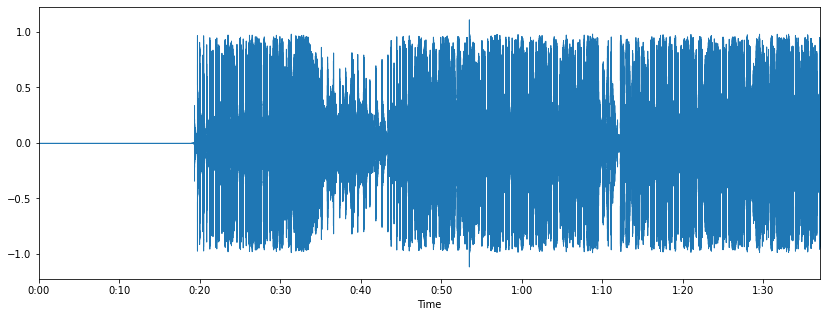

time: 522 ms


In [10]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(X[0, 0], sr=22050)

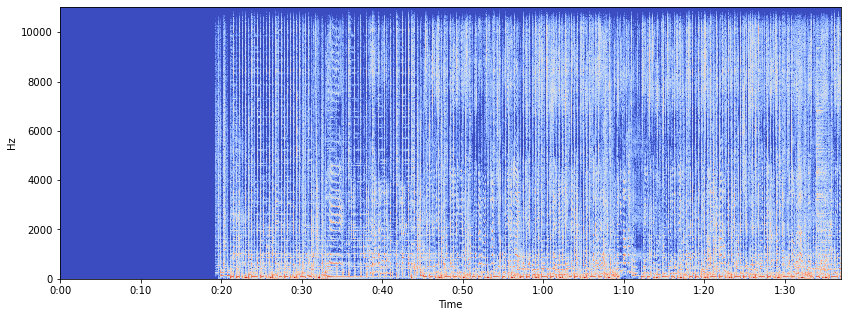

time: 1.76 s


In [11]:
Xdb = librosa.amplitude_to_db(abs(librosa.stft(X[0,0])))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='hz')

In [12]:
model = MusicNet().to(device)

time: 1.38 s


In [13]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y, dtype=torch.long)
print(X_tensor.dtype)
print(y_tensor.dtype)

torch.float32
torch.int64
time: 21.2 ms


In [14]:
with torch.no_grad():
    logits = model(X_tensor.to(device))
    preds = torch.argmax(logits, dim=1)
    print(preds)
    del logits
    torch.cuda.empty_cache()

tensor([2, 2, 2, 2, 2, 2, 2], device='cuda:0')
time: 1.12 s


In [18]:
# Train the model
def train(model, data, batch_size, lr, epochs):
    X, y = data
    
    # Loading utilities
    dataset = TensorDataset(torch.from_numpy(X).to(torch.float32), torch.from_numpy(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_list = []
    for epoch in range(epochs):
        current_loss = 0
        for i, data_sample in enumerate(loader):
            inputs, labels = data_sample
            optimizer.zero_grad()

            # Run the forward pass
            logits = model(inputs.to(device))
            loss = criterion(logits, labels.to(device))

            # Backprop and perform Adam optimisation
            loss.backward()
            optimizer.step()
            current_loss += loss

        if epoch+1 % 10 == 0:
            loss_list.append(current_loss)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {current_loss}')

time: 1.6 ms


In [19]:
train(model, (X, y), batch_size=3, lr=0.01, epochs=100)

time: 47.4 s
